<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/Lab1_AddImage_y_subs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [ ]:
file_name = "plaza"
file_name2 = "leon"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

(543, 832, 3)


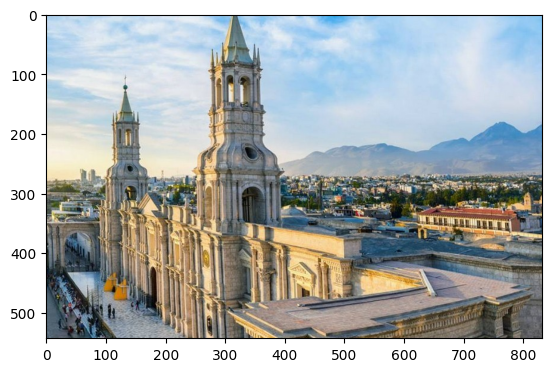

In [ ]:
img = plt.imread(path+file_name+'.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

(545, 786, 3)


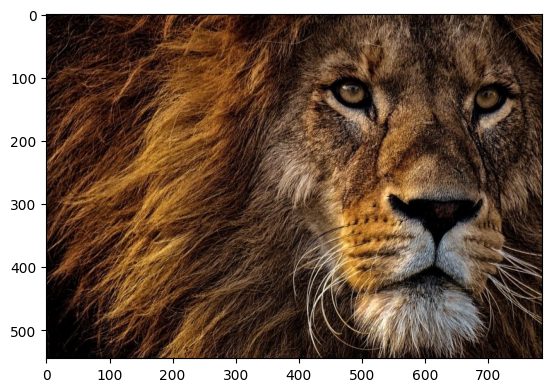

In [ ]:
img2 = plt.imread(path+file_name2+'.jpg')
print(img2.shape)
plt.imshow(img2)
plt.show()

In [ ]:
import os
import subprocess

In [ ]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [ ]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [ ]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>
#include <numeric>
#include <stdlib.h>
#include <stdio.h>
#include <string>

#include <opencv2/core/core.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/opencv.hpp>

using namespace cv;
using namespace std;

int width;
int height;
string file_name = "plaza";
string file_name2 = "leon";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";
float porc = 0.6;

// Max Threads
#define TxB 256

#define CUDA_CHECK_RETURN(value) CheckCudaErrorAux(__FILE__,__LINE__, #value, value)

void image_addition(uchar4* const d_rgbaImage,
                    uchar4* const d_rgbaImage2,
                    uchar4* const d_outputImage,
                    size_t numRows, size_t numCols, float percent);

// Matrices de las imagenes
cv::Mat imageMat;
cv::Mat imageMat2;
cv::Mat imageOutputMat;

// Punteros hacia el inicio de la imagen
// Necesarios para luego liberar memoria
uchar4        *d_rgbaImage__;
uchar4        *d_rgba2Image__;
uchar4        *d_outputImage__;

unsigned char *d_binaryImage__;
unsigned char *d_binary2Image__;
unsigned char *d_notImage__;

size_t numRows() { return imageMat.rows; }
size_t numCols() { return imageMat.cols; }


static void CheckCudaErrorAux (const char *file, unsigned line, const char *statement, cudaError_t err)
{
	if (err == cudaSuccess)
		return;
	std::cerr << statement<<" returned " << cudaGetErrorString(err) << "("<<err<< ") at "<<file<<":"<<line << std::endl;
	exit (1);
}

//Kernel suma media ponderada
__global__
void image_addition_kernel(const uchar4* const rgbaImage,
                           const uchar4* const rgbaImage2,
                                 uchar4* const outputImage,
                           int numRows, int numCols, float percent)
{
  // El mapeo de los componentes uchar4 aRGBA es:
  // .x -> R ; .y -> G ; .z -> B ; .w -> A
  //Nota: Ignoramos el canal alfa
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if( i < numRows*numCols){
    uchar4 px = rgbaImage[i]; // thread pixel to process
    uchar4 px2 = rgbaImage2[i]; // thread pixel to process
    //printf( "Antes: R: %i G: %i B %i \n",px.x,px.y,px.z );

    outputImage[i].x = ( percent * px.x ) + ( ( 1 - percent ) * px2.x );
    outputImage[i].y = ( percent * px.y ) + ( ( 1 - percent ) * px2.y );
    outputImage[i].z = ( percent * px.z ) + ( ( 1 - percent ) * px2.z );


    //printf( "Despues: R: %i G: %i B %i \n",outputImage[i].x,outputImage[i].y,outputImage[i].z );
  }

}

void image_addition(uchar4* const d_rgbaImage,
                    uchar4* const d_rgbaImage2,
                    uchar4* const d_outputImage,
                    size_t numRows, size_t numCols, float percent)
{

  // Dado que no importa la posicion relativa de los pixels
  // en este algoritmo, la estrategia para asignar hilos a
  // bloques y rejillas sera sencillamente la de cubrir
  // a todos los pixeles con hebras en el eje X
  long long int total_px = numRows * numCols;  // total pixels
  long int grids_n = ceil(total_px / TxB); // grids numer
  const dim3 blockSize(TxB, 1, 1);
  const dim3 gridSize(grids_n, 1, 1);
  image_addition_kernel<<<gridSize, blockSize>>>(d_rgbaImage, d_rgbaImage2, d_outputImage, numRows, numCols, percent);

  cudaDeviceSynchronize();
  CUDA_CHECK_RETURN(cudaGetLastError());
}

// Preprocesar 2 imagenes
void preProcessTwo(uchar4 **inputImage,  uchar4 **inputImage2,  uchar4  **outputImage,
                   uchar4 **d_rgbaImage, uchar4 **d_rgbaImage2, uchar4 **d_outputImage,
                   const std::string &filename, const std::string &filename2) {
  //Comprobar que el contexto se inicializa bien
  CUDA_CHECK_RETURN(cudaFree(0));

  cv::Mat image, image2;
  image   = cv::imread(filename.c_str());
  image2  = cv::imread(filename2.c_str());

  if (image.empty() or image2.empty()) {
    std::cerr << "No se pudo abrir el archivo: " << filename << std::endl;
    exit(1);
  }

  cv::cvtColor(image,  imageMat, COLOR_BGR2BGRA);
  cv::cvtColor(image2, imageMat2, COLOR_BGR2BGRA);

  // Reserva memoria para el output
  imageOutputMat.create(image.rows, image.cols, CV_8UC4);

  //This shouldn't ever happen given the way the images are created
  //at least based upon my limited understanding of OpenCV, but better to check
  if (!imageMat.isContinuous() || !imageMat2.isContinuous() || !imageOutputMat.isContinuous())
  {
    std::cerr << "Images aren't continuous!! Exiting." << std::endl;
    exit(1);
  }

  //Apuntamos al comienzo de las filas
  *inputImage   = (uchar4 *)imageMat.ptr<unsigned char>(0);
  *inputImage2  = (uchar4 *)imageMat2.ptr<unsigned char>(0);
  *outputImage  = (uchar4 *)imageOutputMat.ptr<unsigned char>(0);

  const size_t numPixels = numRows() * numCols();
  //Reserva memoria en el dispositivo
  CUDA_CHECK_RETURN(cudaMalloc(d_rgbaImage,   sizeof(uchar4) * numPixels));
  CUDA_CHECK_RETURN(cudaMalloc(d_rgbaImage2,  sizeof(uchar4) * numPixels));
  CUDA_CHECK_RETURN(cudaMalloc(d_outputImage, sizeof(uchar4) * numPixels));
  CUDA_CHECK_RETURN(cudaMemset(*d_outputImage, 0, numPixels * sizeof(uchar4))); // Asegurate de que no queda memoria sin liberar

  // Copia el input en la GPU
  CUDA_CHECK_RETURN(cudaMemcpy(*d_rgbaImage,  *inputImage, sizeof(uchar4) * numPixels, cudaMemcpyHostToDevice));
  CUDA_CHECK_RETURN(cudaMemcpy(*d_rgbaImage2, *inputImage2, sizeof(uchar4) * numPixels, cudaMemcpyHostToDevice));

  d_rgbaImage__   = *d_rgbaImage;
  d_rgba2Image__  = *d_rgbaImage2;
  d_outputImage__ = *d_outputImage;
}


int main(void)
{
	uchar4        *h_rgbaImage,   *d_rgbaImage;
  uchar4        *h_rgbaImage2,  *d_rgbaImage2;
  uchar4        *h_outputImage, *d_outputImage;

  //Variable para binarizar
  unsigned char *h_binaryImage,  *d_binaryImage;   //imagen binarizada
  unsigned char *h_binary2Image, *d_binary2Image;  //imagen binarizada
  unsigned char *h_notImage,     *d_notImage;      //imagen negada

  //Datos auxiliares
  std::string input_file;
  std::string input_file2;
  std::string output_file;
  float aux;

  input_file  = path + file_name + ".jpg";
  input_file2 = path + file_name2 + ".jpg";
  aux         = porc; //porcentaje suma
  output_file = path + file_name + "_add_gpu.jpg";

  preProcessTwo(&h_rgbaImage, &h_rgbaImage2, &h_outputImage,
              &d_rgbaImage, &d_rgbaImage2, &d_outputImage,
              input_file, input_file2);


  image_addition(d_rgbaImage, d_rgbaImage2, d_outputImage,
                  numRows(), numCols(), aux);

  size_t numPixels = numRows()*numCols();
  CUDA_CHECK_RETURN(cudaMemcpy(h_outputImage, d_outputImage, sizeof(uchar4) * numPixels, cudaMemcpyDeviceToHost));

  cv::Mat output(numRows(), numCols(), CV_8UC4, (void*)h_outputImage);

  cv::Mat MatOutput;
  cv::cvtColor(output, MatOutput, cv::COLOR_RGBA2BGR);
  cv::imwrite(output_file.c_str(), MatOutput);

  /* Libera memoria */
  cudaFree(d_rgbaImage__);
  cudaFree(d_rgba2Image__);
  cudaFree(d_outputImage__);

	return 0;
}


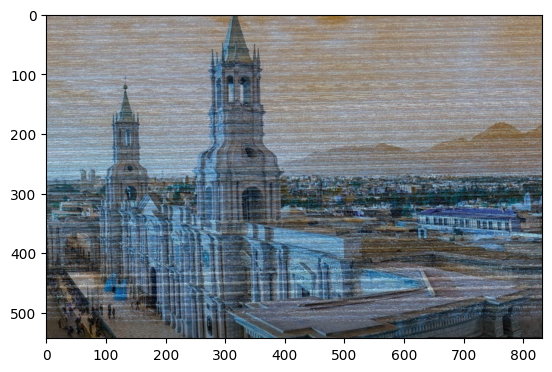

In [ ]:
img = plt.imread(path+file_name+'_add_gpu.jpg')
plt.imshow(img)
plt.show()

In [ ]:
def suma(img1, img2):
	# Dimensions
	heigth = img2.shape[0]
	width = img2.shape[1]
	if img1.shape[0]>img2.shape[0]:
		heigth = img2.shape[0]
	if img1.shape[1]>img2.shape[1]:
		width = img2.shape[1]
	# Creating matrix
	img_out = np.zeros((heigth, width, 3), np.int32)
	s1 = lambda x: x/2
	img1 = s1(img1)
	img2 = s1(img2)
	for x in range(0, heigth, 1):
	    for y in range(0, width, 1):
	        img_out[x][y] = img1[x][y] + img2[x][y]
	return img_out

def subtraccion(img1, img2, c):
  # Dimensions
	heigth = img2.shape[0]
	width = img2.shape[1]
  # Creating matrix
	img_out = np.zeros((heigth, width, 3), np.int32)
	for x in range(0, heigth, 1):
		for y in range(0, width, 1):
			img_out[x][y] = ((img1[x][y]/2) - (img2[x][y]/2)) + c
	return img_out


In [ ]:
height = 820
width  = 540
img1   = cv2.imread(path+file_name+'.jpg')
img1   = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1re = cv2.resize(img1, (height,width),interpolation = cv2.INTER_AREA)
img2   = cv2.imread(path+file_name2+'.jpg')
img2   = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2re = cv2.resize(img2, (height,width),interpolation = cv2.INTER_AREA)

img_out1 = suma(img1re,img2re)
cv2.imwrite(path+file_name+"_add.jpg",img_out1)

img_out2 = subtraccion(img1re, img2re, 100)
cv2.imwrite(path+file_name+"_sub.jpg",img_out2)

cv2.destroyAllWindows()
cv2.waitKey(1)
exit()

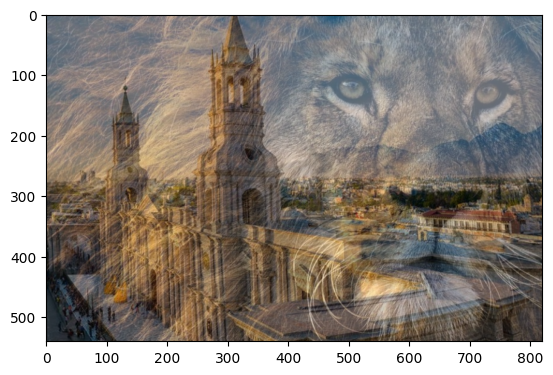

In [ ]:
plt.imshow(img_out1)
plt.show()

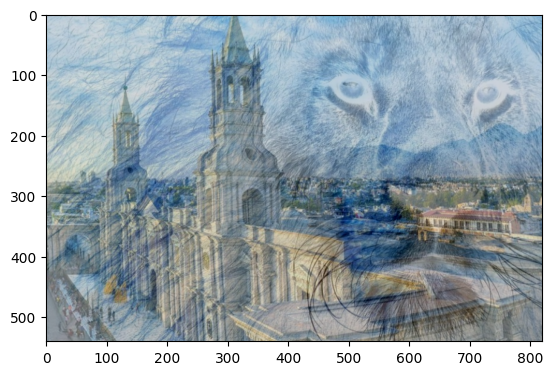

In [ ]:
plt.imshow(img_out2)
plt.show()